# Week5 Assignments 

In this week's assignments, you will build and run a KFP pipeline that trains and deploys a LightGBM regression model to predict public bike sharing demand. You will first create some KFP components following the instructions below and then create a KFP pipeline using your KFP components. 

**Guidelines of submitting the assignments**:
- For each assignment, a code skeleton is provided. Please put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments.
- The final assignment also requires you to capture screenshots in order to earn points. Please put your screenshots into a single PDF file. 
- When preparing your submission, be sure to include your assignment notebook with code cell outputs. It's important that these outputs are up-to-date and reflect the latest state of your code, as your grades may depend on them. Additionally, please include the PDF file that contains your screenshots in your submission. 

In [1]:
# Import packages
import kfp
import kfp.dsl as dsl
from kfp.aws import use_aws_secret
from kfp.v2.dsl import (
    component,
    Input,
    Output,
    Dataset
)
from typing import NamedTuple, Dict, Any, Tuple

from unittest.mock import create_autospec
import pandas as pd
import os
from send_requests import send_requests

In [2]:
# Connect to KFP client, remember to ensure you're using the correct kubectl context
client = kfp.Client(host=None)

## Assignment 1: Create KFP components (10 points)
You will need to create five KFP components, each KFP component gives 2 points. 

### 1a) Create a pull data component

This KFP component:

1) downloads the dataset (a CSV file) as a Pandas DataFrame from a URL given as an input;

2) saves the DataFrame to an output of type Dataset so that the dataset can be used by other KFP components.

The dataset can be found [here](https://raw.githubusercontent.com/yumoL/mlops_eng_course_datasets/master/intro/bike-demanding/train_full.csv). It's the same bike sharing demand dataset used in some of the previous weeks. Below is the explanation of each columns in the dataset:

**Variables**:

| Column name |  Explanation | type |
|-------------|---------------|----|
| datetime    | hourly date + timestamp| object
| season      | 1 = spring, 2 = summer, 3 = fall, 4 = winter | integer
| holiday     | whether the day is considered a holiday | integer
| workingday  | 1 if day is neither weekend nor holiday, otherwise is 0. | integer
| weather     | 1: Clear, Few clouds, Partly cloudy, Partly cloudy; 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist; 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds; 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog | integer
| temp        | temperature in Celsius | float
| atemp       | "feels like" temperature in Celsius | float
| humidity    | relative humidity | integer
| windspeed   | wind speed | float

**Targets**: 

| Column name | Explanation                                     | Type
|-------------|-------------------------------------------------| ----|
| casual      | number of non-registered user rentals initiated | integer
| registered  | number of registered user rentals initiated     | integer
| count       | number of total rentals                         | integer


In [3]:
@component(
    base_image="python:3.10",
    packages_to_install=["pandas~=1.5.3"],
)
def pull_data(url: str, data: Output[Dataset]):
    """
    Args:
        url: Dataset URL
        data: Output of type Dataset where the downloaded dataset is saved
    """
    ### START CODE HERE
    import pandas as pd
    df = pd.read_csv(url)
    df.to_csv(data.path, index=None)
    ### END CODE HERE

It seems there isn't a simply way to directly test the KFP component created by the @component decorator. A workaround is to access the inner decorated Python function through the component attribute `python_func`. 

Let's test if your `pull_data` works correctly.

In [4]:
# Mock an output Dataset
raw_dataset = create_autospec(Dataset, metadata=dict(), path="raw_data.csv")

pull_data.python_func(
    url="https://raw.githubusercontent.com/yumoL/mlops_eng_course_datasets/master/intro/bike-demanding/train_full.csv", 
    data=raw_dataset)

raw_df = pd.read_csv("raw_data.csv")
print(f"The shape of the downloaded DataFrame should be {raw_df.shape}.")
raw_df.head()

The shape of the downloaded DataFrame should be (10886, 12).


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Expected output:

The shape of the downloaded DataFrame should be (10886, 12).

![](./images/raw-df.png)

### 1b) Create a data preprocessing component

This KFP component: 

1. reads a dataset from an input of type Dataset;

1. converts the "datetime" column into Pandas datetime object;

1. creates three more features (hour, day and month) from the "datetime" column;

1. removes the "datetime", "casual" and "registered" columns; 

1. splits the dataset into a training and a test dataset, using the last week of the dataset as the test dataset;

1. saves the training and test datasets into two separate outputs of type Dataset.

The dataset contains data from two years and the data were generated on an hourly basis. 

The resulted datasets should have 12 columns: season, holiday, workingday, weather, temp, atemp, humidity, windspeed, casual, registered, count, hour, day, and month. For example:

![](./images/train-df.png)

The following links may be helpful:
- [pandas.to_datetime](https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.to_datetime.html)
- [pandas.Series.dt.*](https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.Series.dt.hour.html)
- [pandas.DataFrame.drop](https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.DataFrame.drop.html)

In [5]:
@component(
    base_image="python:3.10",
    packages_to_install=["pandas~=1.5.3"],
)
def preprocess_data(
    data: Input[Dataset],
    train_set: Output[Dataset],
    test_set: Output[Dataset]
):
    """
    Args: 
        data: Input of type Dataset where the dataset is read from
        train_set: Output of type Dataset where the training dataset is saved
        test_set: Output of type Dataset where the test dataset is saved  
    """
    ### START CODE HERE
    import pandas as pd
    from datetime import datetime, timedelta

    data = pd.read_csv(data.path, sep=",")
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['hour'] = data['datetime'].dt.hour
    data['day'] = data['datetime'].dt.day
    data['month'] = data['datetime'].dt.month

    data.drop(['casual', 'registered'], axis=1, inplace=True)
     # Filter out the last 7 days dates 
    max_date = data['datetime'].max()
    first_date = max_date - timedelta(days=7)

    train = data[data['datetime'] <= first_date]
    test = data[(data['datetime'] > first_date) & (data['datetime'] <= max_date)]

    # mask = (data['day'] >= 13) & (data['day'] <= 19) & (data['month'] == 12) & (data['year'] == 2012)    
    # test_set_data = data[mask]
    # train_set_data = data[~mask]
    
    test = test.drop(['datetime'], axis=1)
    train = train.drop(['datetime'], axis=1)


    train.to_csv(train_set.path, index=False)
    test.to_csv(test_set.path, index=False)

    ### END CODE HERE

In [6]:
train_dataset = create_autospec(Dataset, metadata=dict(), path="train_data.csv")
test_dataset = create_autospec(Dataset, metadata=dict(), path="test_data.csv")

preprocess_data.python_func(data=raw_dataset, train_set=train_dataset, test_set=test_dataset)

train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")
print(f"The training DataFrame should have a shape of {train_df.shape} and the following columns: {train_df.columns}")
print(f"The testing DataFrame should have a shape of {test_df.shape} and the following columns: {test_df.columns}")

The training DataFrame should have a shape of (10718, 12) and the following columns: Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'hour', 'day', 'month'],
      dtype='object')
The testing DataFrame should have a shape of (168, 12) and the following columns: Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'hour', 'day', 'month'],
      dtype='object')


Expected output:
```text
The training DataFrame should have a shape of (10718, 12) and the following columns: Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count', 'hour', 'day', 'month'], dtype='object')
The testing DataFrame should have a shape of (168, 12) and the following columns: Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count', 'hour', 'day', 'month'], dtype='object')
```

### 1c) Create a train component

This component 

1) loads the training and test datasets from two inputs of type Dataset, respectively;

2) uses the training dataset and the given hyperparameters to train a [LightGBM regression model](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html). The hyperparameters are given in a dictionary, e.g., `{"num_leaves": 1023, "learning_rate": 0.05}`. In the dictionary, each key is an argument name accepted by the LGBMRegressor class and the value is the value assigned to the corresponding argument;

3) evaluates the trained model against the testing dataset, the evaluation metrics to be used are **mean squared error, mean absolute error, r2_score**;

4) logs the configured hyperparameters and evaluation metrics to an MLflow Run. The following information is given as the component inputs: the name of the MLflow Experiment under which the MLflow Run should be stored, the URIs of the MLflow service and the artifact store;

5) registers the model to MLflow, the artifact path relative to the MLflow Run is also given as an input.

**Note**:
- When logging hyperparameters, you can use the keys of the dictionary as the parameter names.
- When logging metrics, please use **"rmse", "mae", "r2"** as the metric names. 

In [7]:
@component(
    base_image="python:3.10",
    packages_to_install=["pandas~=1.5.3", "numpy", "lightgbm~=3.3.5", "scikit-learn~=1.3.2", "mlflow==2.3.2", "boto3~=1.28.85"],
)
def train(
    train_set: Input[Dataset],
    test_set: Input[Dataset],
    mlflow_experiment_name: str,
    mlflow_tracking_uri: str,
    mlflow_s3_endpoint_url: str,
    model_artifact_path: str,
    hyperparams: Dict[str, Any],
    target: str = "count"
) -> NamedTuple("Output", [("storage_uri", str), ("run_id", str),]):
    """
    Args:
        train_set: Input where the training dataset is saved
        test_set: Input where the test dataset is saved
        mlflow_experiment_name: Name of the MLflow experiment
        mlflow_tracking_uri: URI of MLflow's tracking server
        mlflow_s3_endpoint_url: URL of MLflow's artifact store
        model_artifact_path: The path where the artifacts of the model are stored in MLflow's artifact store. It's relative to the MLflow Run.
        hyperparams: Hyperparameters that need to be configured. The hyperparameters will be passed as a dictionary like {"num_leaves": 1023, "learning_rate": 0.05}
        target: Target column name
    
    Returns: 
        namedtuple("Output", ["storage_uri", "run_id"]) where storage_uri (e.g., s3://mlflow/13/e5559bc.../artifacts/bike-demand) is the S3 URI of the saved model in
        Mlflow's artifact store and run_id the ID of the MLflow run that produces the model
    """
    ### START CODE HERE
    import numpy as np
    import pandas as pd
    import lightgbm as lgb
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import mlflow
    import mlflow.sklearn
    import os
    import logging
    from collections import namedtuple

    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2
    
    os.environ["MLFLOW_S3_ENDPOINT_URL"] = mlflow_s3_endpoint_url

    #load data
    train = pd.read_csv(train_set.path)
    test = pd.read_csv(test_set.path)

    train_x = train.drop([target], axis=1)
    test_x = test.drop([target], axis=1)
    train_y = train[[target]]
    test_y = test[[target]]

    learning_rate = hyperparams["learning_rate"]
    num_leaves = hyperparams["num_leaves"]
    random_state = hyperparams["random_state"]

    hyperparameters={
        "learning_rate": learning_rate,
        "num_leaves": num_leaves,
        "random_state": random_state
    }

    logger.info(f"Using MLflow tracking URI: {mlflow_tracking_uri}")
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    
    logger.info(f"Using MLflow experiment: {mlflow_experiment_name}")
    mlflow.set_experiment(mlflow_experiment_name)

    with mlflow.start_run() as run:
        run_id = run.info.run_id
        logger.info(f"Run ID: {run_id}")
        model = lgb.LGBMRegressor(**hyperparameters)

        logger.info("Fitting model...")
        model.fit(train_x, train_y)

        logger.info("Predicting...")
        predicted_qualities = model.predict(test_x)
        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)
        logger.info("LightGBM regression model (learning_rate=%f, num_leaves=%f, random_state=%f):" % (learning_rate, num_leaves, random_state))
        logger.info("RMSE: %s" % rmse)
        logger.info("MAE: %s" % mae)
        logger.info("R2: %s" % r2)
        
        logger.info("Logging parameters and metrics to MLflow")
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_leaves", num_leaves)
        mlflow.log_param("random_state", random_state)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        logger.info("Logging trained model")
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path=model_artifact_path,
            registered_model_name="LightGBMRegressorModel",
            serialization_format="pickle"
        )

        output = namedtuple("Output", ["storage_uri", "run_id"])
        return output(mlflow.get_artifact_uri(artifact_path=model_artifact_path), run_id)

    ### END CODE HERE
   

In [8]:
# These are needed for testing the function outside the MLOps platform
os.environ["AWS_ACCESS_KEY_ID"] = "minioadmin"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minioadmin"

train_output = train.python_func(
    train_set=train_dataset,
    test_set=test_dataset,
    mlflow_experiment_name="test",
    mlflow_tracking_uri="http://mlflow-server.local",
    mlflow_s3_endpoint_url="http://mlflow-minio.local",
    model_artifact_path="test-model",
    hyperparams={"learning_rate": 0.2, "num_leaves": 63, "random_state": 42},
    target="count"
)

INFO:__main__:Using MLflow tracking URI: http://mlflow-server.local
INFO:__main__:Using MLflow experiment: test
INFO:__main__:Run ID: 07b2b8d69219462494a14c6daf5269a7
INFO:__main__:Fitting model...
INFO:__main__:Predicting...
INFO:__main__:LightGBM regression model (learning_rate=0.200000, num_leaves=63.000000, random_state=42.000000):
INFO:__main__:RMSE: 79.49345042990697
INFO:__main__:MAE: 58.89191297473423
INFO:__main__:R2: 0.7801542541021345
INFO:__main__:Logging parameters and metrics to MLflow
INFO:__main__:Logging trained model
/home/user/anaconda3/envs/mlops_eng/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
INFO:botocore.credentials:Found credentials in environment variables.
Registered model 'LightGBMRegressorModel' already exists. Creating a new version of this model...
2023/12/07 20:57:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds f

In [9]:
train_output

Output(storage_uri='s3://mlflow/6/07b2b8d69219462494a14c6daf5269a7/artifacts/test-model', run_id='07b2b8d69219462494a14c6daf5269a7')

Expected output:
```text
Output(storage_uri='s3://mlflow/<MLflow-Experiment-ID>/<MLflow-Run-ID>/artifacts/test-model', run_id=<MLflow-Run-ID>)
```

At [http://mlflow-server.local](http://mlflow-server.local), you should see an MLflow Experiment named "test" and there is an MLflow Run under the "test" experiment. You should also see a registered model associated to the MLflow Run:

<img src="./images/mlflow-test-run.png" width="1000" />
<img src="./images/mlflow-test-model.png" width="1000" />

The metric values may vary depending on how your model was trained. The key point is that all hyperparameters and metrics are logged. 

![Screenshot from 2023-12-05 14-04-33.png](<attachment:Screenshot from 2023-12-05 14-04-33.png>)
![Screenshot from 2023-12-05 14-07-21.png](<attachment:Screenshot from 2023-12-05 14-07-21.png>)
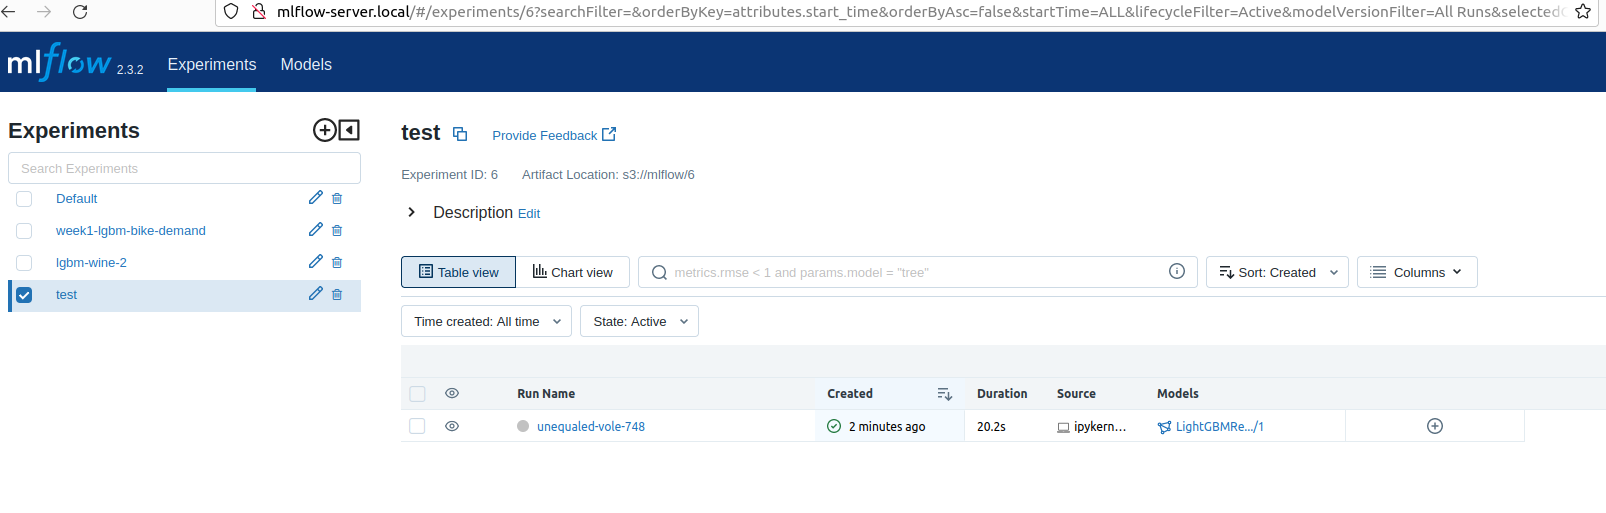
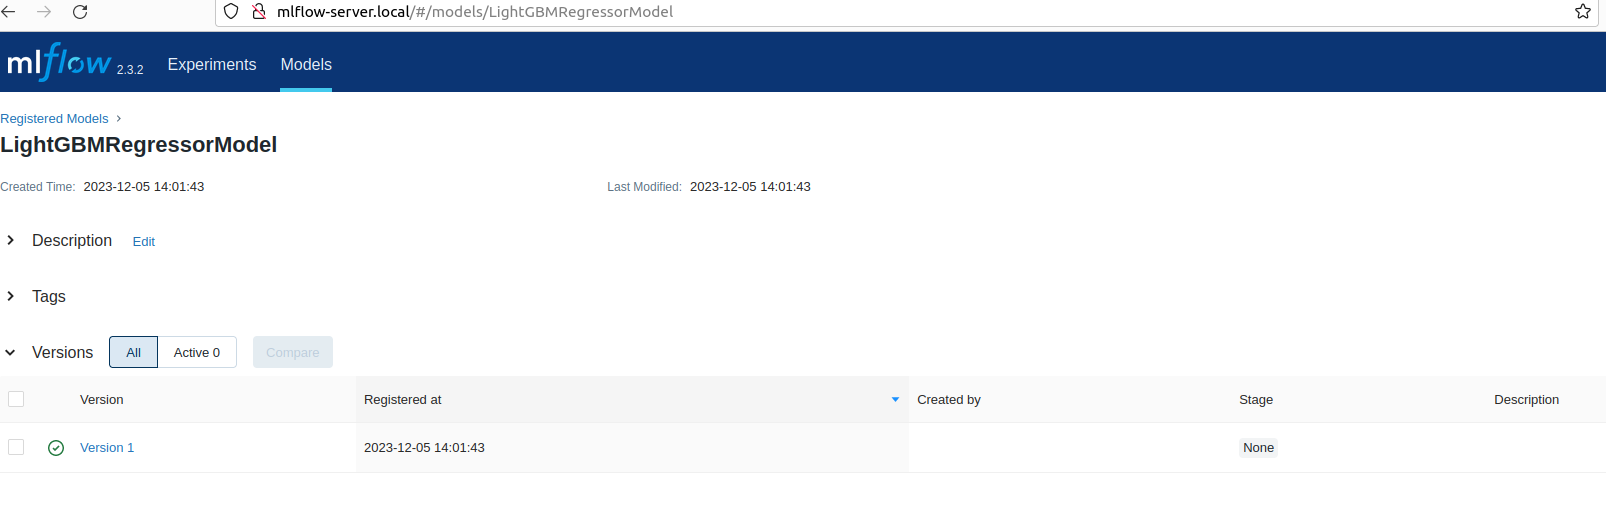

### 1d) Create a validate component

This component 

1) uses an MLflow Run ID to fetch the evaluation metrics logged at that Run from the MLflow service. The MLflow Run ID and the URI of the MLflow service are given as inputs;

2) compares the evaluation metrics with a set of thresholds specified in a dictionary, e.g., `{"rmse": (100, "minimize"), "r2": (0.1, "maximize"), "mae": (100, "minimize")}`. The threshold dictionary has three keys "rmse", "mae", and "r2", which correspond to the metric names used when the `train` component logs the metrics to MLflow. For each key in the dictionary, a tuple is provided as its value. The first element of the tuple represents the threshold, while the second element indicates the optimization direction of the metric. To pass the validation, a metric should be below its threshold when the optimization direction is "minimize" or above its threshold when the direction is "maximize". If any metric fails to meet these criteria, the validation fails.

The component should return True if the validation succeeds, otherwise false. 

Hint: You can use [get_run()](https://mlflow.org/docs/2.3.2/python_api/mlflow.client.html?highlight=mlflowclient#mlflow.client.MlflowClient.get_run) th find an MLflow Run. 

In [10]:
@component(
    base_image="python:3.10",
    packages_to_install=["numpy", "mlflow==2.3.2"],
)
def validate(
    run_id: str,
    mlflow_tracking_uri: str,
    threshold_metrics: Dict[str, Tuple[int, str]]
) -> bool:
    """
    Args:
        run_id: MLflow run ID, by which the evaluation metrics can be fetched
        mlflow_tracking_uri: URI of the MLflow tracking service,
        threshold_metrics: Minimum threshold values for each metric
    Returns:
        Boolean indicating whether the metrics pass the threshold or not. True means all metrics are smaller than 
    """
    ### START CODE HERE
    import mlflow

    mlflow.set_tracking_uri(mlflow_tracking_uri)
    run = mlflow.get_run(run_id)
    metrics = run.data.metrics

    for metric_name, (threshold, optimization_direction) in threshold_metrics.items():
        metric_value = metrics[metric_name]

        if (optimization_direction == "minimize" and metric_value > threshold) or (optimization_direction == "maximize" and metric_value < threshold):
            return False

    return True
    ### END CODE HERE

In [11]:
# A loose threshold to guarantee a successful validation
validate_threshold_metrics = {"rmse": (100, "minimize"), "r2": (0.1, "maximize"), "mae": (100, "minimize")}

# A strict threshold so that the validation will fail
strict_validate_threshold_metrics = {"rmse": (100, "minimize"), "r2": (0.99999, "maximize"), "mae": (0.1, "minimize")}

validation_output = validate.python_func(
    run_id=train_output.run_id,
    mlflow_tracking_uri="http://mlflow-server.local",
    threshold_metrics=validate_threshold_metrics
)
print(validation_output) #should be True

validation_output_strict = validate.python_func(
    run_id=train_output.run_id,
    mlflow_tracking_uri="http://mlflow-server.local",
    threshold_metrics=strict_validate_threshold_metrics
)
print(validation_output_strict) #should be False

True
False


### 1e) Create a deploy model component

This component uses KServe Python SDK to deploy the trained model to KServe in the "kserve-inference" namespace. The component should create a new inference service or update an existing one. In the tutorial, you may notice that the component used for model deployment may be completed though the deployed inference service is not yet ready. Here, the component should remain running until the status of the deployed inference service is ready or a timeout of 6 minutes is reached.

The name of the inference service and the S3 URI of the model are given as inputs.

**Hint**: 
- Using the LightGBM server provided by KServe doesn't work because the model saved by MLflow is in the pickled format, which is different from the format supported by KServe's LightGBM server. You can check [here](https://github.com/kserve/kserve/issues/2483) on how to use KServe SDK to deploy a model saved by MLflow.
- [kserve.wait_isvc_ready](https://kserve.github.io/website/0.10/sdk_docs/docs/KServeClient/#wait_isvc_ready)

In [18]:
@component(
    base_image="python:3.10",
    packages_to_install=["kserve==0.10.1"],
)
def deploy_model(model_name: str, storage_uri: str):
    """
    Args:
        model_name: the name of the deployed inference service
        storage_uri: the URI of the saved model in MLflow's artifact store
    """
    from kubernetes import client
    from kserve import KServeClient
    from kserve import constants
    from kserve import V1beta1InferenceService
    from kserve import V1beta1InferenceServiceSpec
    from kserve import V1beta1PredictorSpec
    from kserve import V1beta1ModelSpec
    from kserve import V1beta1ModelFormat
    import logging

    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    namespace = "kserve-inference"
    service_account_name = "kserve-sa"
    api_version = constants.KSERVE_V1BETA1
    logger.info(f"MODEL URI: {storage_uri}")
    
    modelspec = V1beta1ModelSpec(
        storage_uri=storage_uri,
        model_format=V1beta1ModelFormat(name="mlflow"),
        protocol_version="v2"
    )
    
    ### START CODE HERE
    isvc = V1beta1InferenceService(api_version=api_version,
                               kind=constants.KSERVE_KIND,
                               metadata=client.V1ObjectMeta(
                                   name=model_name, namespace=namespace),
                               spec=V1beta1InferenceServiceSpec(
                                    predictor=V1beta1PredictorSpec(
                                       service_account_name = service_account_name,
                                       model=modelspec))
                               )

    kserve = KServeClient()
    
    try:
        kserve.create(inferenceservice=isvc)
        kserve.wait_isvc_ready(name=model_name, timeout_seconds=360)   
    except RuntimeError:
        kserve.patch(name=model_name, inferenceservice=isvc, namespace=namespace)

    
    ### END CODE HERE
    

In [19]:
deploy_model.python_func(model_name="test-bike-demand", storage_uri=train_output.storage_uri)

INFO:__main__:MODEL URI: s3://mlflow/6/07b2b8d69219462494a14c6daf5269a7/artifacts/test-model


In [20]:
# Ensure the "test-bike-demand" inference service is ready
!kubectl -n kserve-inference get isvc test-bike-demand

NAME               URL                                                    READY   PREV   LATEST   PREVROLLEDOUTREVISION   LATESTREADYREVISION                        AGE
test-bike-demand   http://test-bike-demand.kserve-inference.example.com   True           100                              test-bike-demand-predictor-default-00001   2m56s


In [21]:
# Send a request to the inference service
send_requests(isvc_name="test-bike-demand")

{"model_name":"test-bike-demand","model_version":null,"id":"3d44212b-1aa9-42b6-9106-f6f5ed16f768","parameters":null,"outputs":[{"name":"predict","shape":[2],"datatype":"FP64","parameters":null,"data":[42.1026868829854,30.14696834831473]}]}


Expected output:
```text
{"model_name":"test-bike-demand","model_version":null,"id":"4a592a3e-bfe3-46b4-a07b-c8dc87954b67","parameters":null,"outputs":[{"name":"predict","shape":[2],"datatype":"FP64","parameters":null,"data":[42.1026868829854,30.14696834831473]}]}
```
The ID may vary. The prediction values may also vary depending on how your model was trained. The key point is that your output follows the same format as the expected one.  

In [22]:
# Delete the testing inference service
!kubectl -n kserve-inference delete isvc test-bike-demand

inferenceservice.serving.kserve.io "test-bike-demand" deleted


## Assignment 2:  Create a KFP pipeline (2 points)
You need to create a KFP pipeline using all the KFP components you created. 

The KFP components should perform their tasks in the following order: 

<img src="./images/kfp-assignment.jpg" />

(The other inputs needed by the components are provided as arguments of the `pipeline` function.)

The **deploy model component** should perform its task only if the validation task succeeds. You can use [dsl.Condition](https://www.kubeflow.org/docs/components/pipelines/v2/pipelines/control-flow/) to manage conditions in Kubeflow Pipelines. 

**Hints**: 
- You need to assign the needed credentials to the model training task so that the task can upload artifacts to MLflow's artifact store (MinIO). (Please check the tutorial for more details.) 
- We recall that if a component has a single Parameter output, this output can be accessed by `task.output`.
- A boolean output will be converted to a string by Kubeflow Pipelines. For example, if there is component that returns a boolean as its output:
```python
@component()
def component1():
    if ...:
        return True
    return False
task1 = component1()
```
then `task1.output` is the string "true" instead of the boolean True. 

In [23]:
@dsl.pipeline(
    name="bike-demand-pipeline",
    description="An example pipeline that deploys a model for bike demanding prediction"
)
def pipeline(
    url: str,
    target: str,
    mlflow_experiment_name: str,
    mlflow_tracking_uri: str,
    mlflow_s3_endpoint_url: str,
    model_name: str,
    hyperparams: Dict[str, Any],
    threshold_metrics: Dict[str, Tuple[int, str]]
):
    """
    Args:
        url: URL for downloading the dataset
        target: Target column name of the dataset
        mlflow_experiment_name: Name of the MLflow experiment
        mlflow_tracking_uri: URI of MLflow's tracking server
        mlflow_s3_endpoint_url: URL of MLflow's artifact store
        model_name: The name of the KServe inference service. It's also used as the model's artifact path
        hyperparams: A dictionary of hyperparameters for training the LightGBM model, same as the one used by the train component
        threshold_metrics: A dictionary of threshold values for each metric, same as the one used by the validate component 
    """
    ### START CODE HERE
    # Call a component in a pipeline definition
    pull_task = pull_data(url)

    preprocess_task = preprocess_data(data=pull_task.outputs["data"])

    train_task = train(
        train_set=preprocess_task.outputs["train_set"],
        test_set=preprocess_task.outputs["test_set"],
        target=target,
        mlflow_experiment_name=mlflow_experiment_name,
        mlflow_tracking_uri=mlflow_tracking_uri,
        mlflow_s3_endpoint_url=mlflow_s3_endpoint_url,
        model_artifact_path=model_name,
        hyperparams=hyperparams,
    )

    train_task.apply(use_aws_secret(secret_name="aws-secret"))

    validation_result = validate(
        run_id=train_task.outputs["run_id"],
        mlflow_tracking_uri=mlflow_tracking_uri,
        threshold_metrics=threshold_metrics
    )

    with dsl.Condition(validation_result.output == 'true'):
        deploy_model(
            model_name=model_name,
            storage_uri=train_task.outputs["storage_uri"]
        )
    ### END CODE HERE

## Submit a KFP run
After defining your KFP pipeline, you can test it by triggering a KFP run of your KFP pipeline. 

In [24]:
# Specify pipeline argument values

# A loose threshold to guarantee a successful validation
validate_threshold_metrics = {"rmse": (100, "minimize"), "r2": (0.1, "maximize"), "mae": (100, "minimize")}

# A strict threshold so that the validation will fail
strict_validate_threshold_metrics = {"rmse": (0.1, "minimize"), "r2": (0.99999, "maximize"), "mae": (0.1, "minimize")}

url = "https://raw.githubusercontent.com/yumoL/mlops_eng_course_datasets/master/intro/bike-demanding/train.csv"

arguments = {
    "url": url,
    "target": "count",
    "mlflow_tracking_uri": "http://mlflow.mlflow.svc.cluster.local:5000",
    "mlflow_s3_endpoint_url": "http://mlflow-minio-service.mlflow.svc.cluster.local:9000",
    "mlflow_experiment_name": "bike-notebook",
    "model_name": "bike-demand",
    "hyperparams": {"learning_rate": 0.2, 
                    "num_leaves": 63, 
                    "random_state": 42},
    "threshold_metrics": validate_threshold_metrics
}

In [25]:
run_name = "bike-run"
experiment_name = "bike-experiment"

client.create_run_from_pipeline_func(
    pipeline_func=pipeline,
    run_name=run_name,
    experiment_name=experiment_name,
    arguments=arguments,
    mode=kfp.dsl.PipelineExecutionMode.V2_COMPATIBLE,
    enable_caching=False
)

/home/user/anaconda3/envs/mlops_eng/lib/python3.10/site-packages/kfp/compiler/compiler.py:79: UserWarning: V2_COMPATIBLE execution mode is at Beta quality. Some pipeline features may not work as expected.
  warnings.warn('V2_COMPATIBLE execution mode is at Beta quality.'


RunPipelineResult(run_id=9cec70f5-2eed-4759-bc81-1a852c7066db)

Go to [http://ml-pipeline-ui.local](http://ml-pipeline-ui.local) to check the running state of the KFP run. Also go to [http://mlflow-server.local](http://mlflow-server.local) to check the created MLflow experiment and the registered model.

Please capture the following screenshots and put them into your PDF file:

1) The Kubeflow Pipelines UI of a succeeded KFP run of this KFP pipeline.
<details>
    <summary>Example</summary>
    <img src="./images/kfp-run-ok.png" width=400/>
</details>

2) The MLflow UI of the created MLflow experiment, including the logged hyperparameters and evaluation metrics.

<details>
    <summary>Example</summary>
    <img src="./images/mlflow-log.png" width=1000/>
</details>

3) The MLflow UI of the registered model.

<details>
    <summary>Example</summary>
    <img src="./images/mlflow-model.png" width=1000/>
</details>

![Screenshot from 2023-12-07 21-10-30.png](<attachment:Screenshot from 2023-12-07 21-10-30.png>) ![Screenshot from 2023-12-07 21-11-00.png](<attachment:Screenshot from 2023-12-07 21-11-00.png>) ![Screenshot from 2023-12-07 21-11-38.png](<attachment:Screenshot from 2023-12-07 21-11-38.png>)
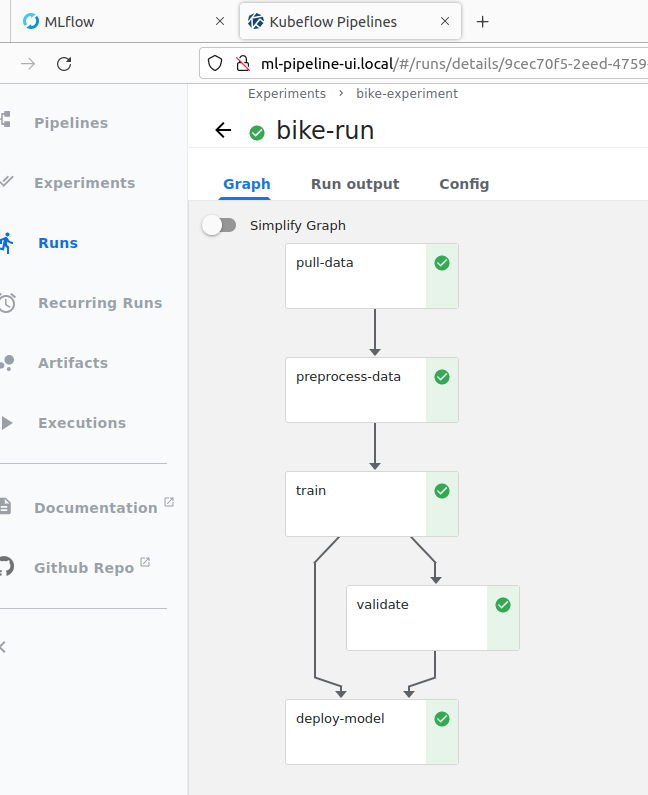
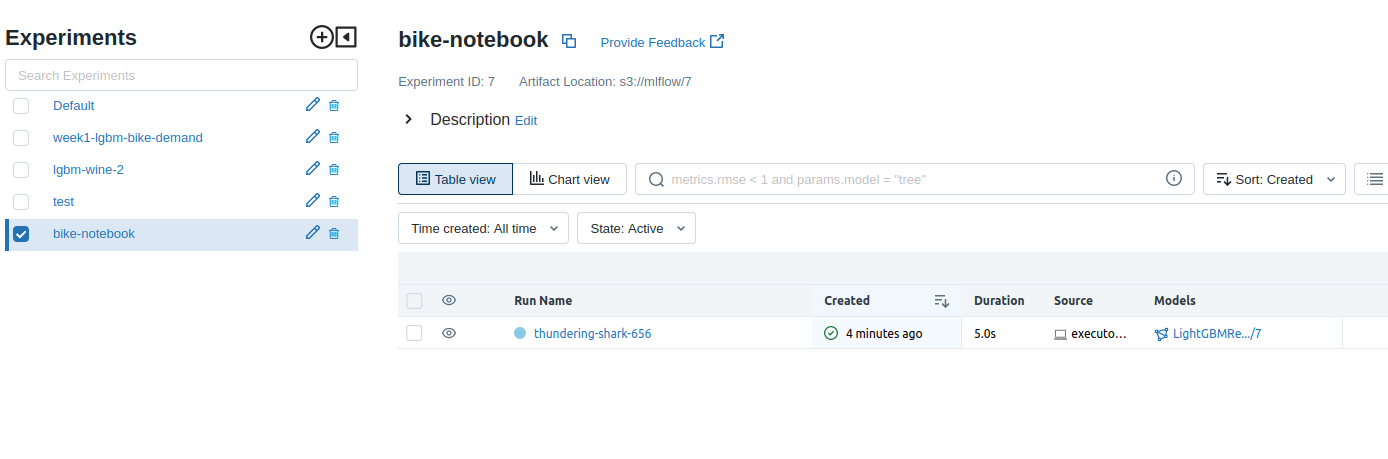
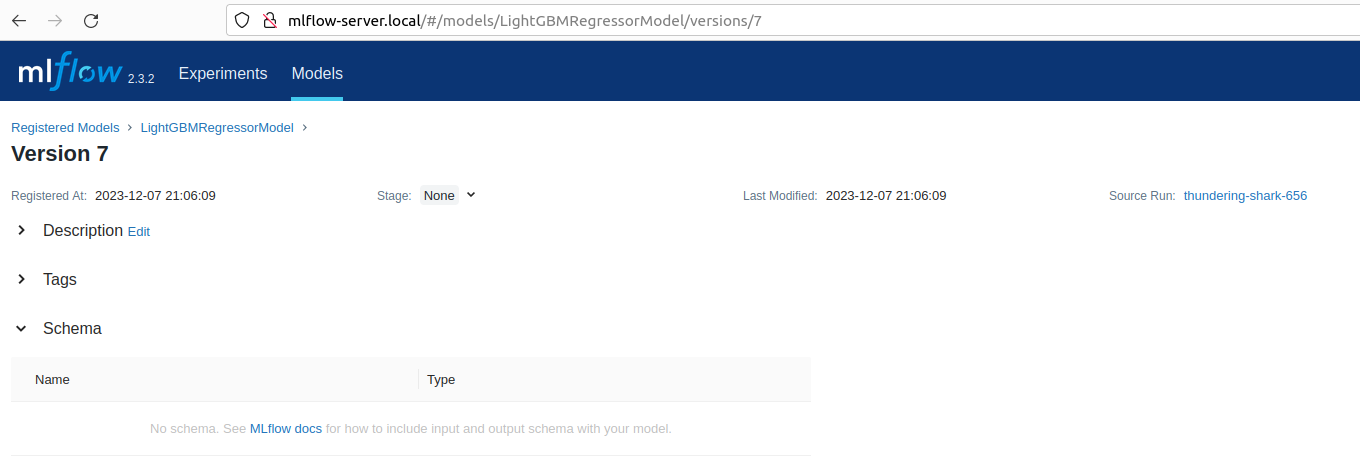

#### A hint for debugging

Your KFP run may fail to complete because of bugs in some of the components. You can further investigate the problems by looking into the component logs:

![](./images/kfp-debug.jpg)

## Testing the inference service
After the KFP run in completed, let's ensure that it's ready.

In [26]:
!kubectl -n kserve-inference get isvc bike-demand

NAME          URL                                               READY   PREV   LATEST   PREVROLLEDOUTREVISION   LATESTREADYREVISION                   AGE
bike-demand   http://bike-demand.kserve-inference.example.com   True           100                              bike-demand-predictor-default-00001   6m57s


After your model is ready in KServe, you can send a request to it.

In [27]:
send_requests(isvc_name="bike-demand")

{"model_name":"bike-demand","model_version":null,"id":"640e70fc-df08-427e-a452-91dc8d02ebd7","parameters":null,"outputs":[{"name":"predict","shape":[2],"datatype":"FP64","parameters":null,"data":[23.64167820300862,35.01148021439017]}]}


Expected output:
```text
{"model_name":"bike-demand","model_version":null,"id":"093f23c2-dd69-4976-8b96-bfd4944e1294","parameters":null,"outputs":[{"name":"predict","shape":[2],"datatype":"FP64","parameters":null,"data":[23.743062591411174,35.72844242242732]}]}
```

## Another run of the pipeline

Now you let's use the "strict_validate_threshold_metrics" as the threshold metrics and start another KFP run of your KFP pipeline. This time the KFP run will skip the deployment task because of the failed validation task. Capture a screenshot of the KFP run where the deployment task is skipped and put this screenshot into your PDF file.

<details>
    <summary>Example</summary>
    <img src="./images/kfp-run-skip-deploy.png" width=500/>
</details>

In [28]:
arguments["threshold_metrics"] = strict_validate_threshold_metrics

run_name = "bike-run-incomplete"

client.create_run_from_pipeline_func(
    pipeline_func=pipeline,
    run_name=run_name,
    experiment_name=experiment_name,
    arguments=arguments,
    mode=kfp.dsl.PipelineExecutionMode.V2_COMPATIBLE,
    enable_caching=False
)

RunPipelineResult(run_id=701b7a65-f25a-4f2c-b3ff-5a1b68634625)

![Screenshot from 2023-12-07 21-23-34.png](<attachment:Screenshot from 2023-12-07 21-23-34.png>)
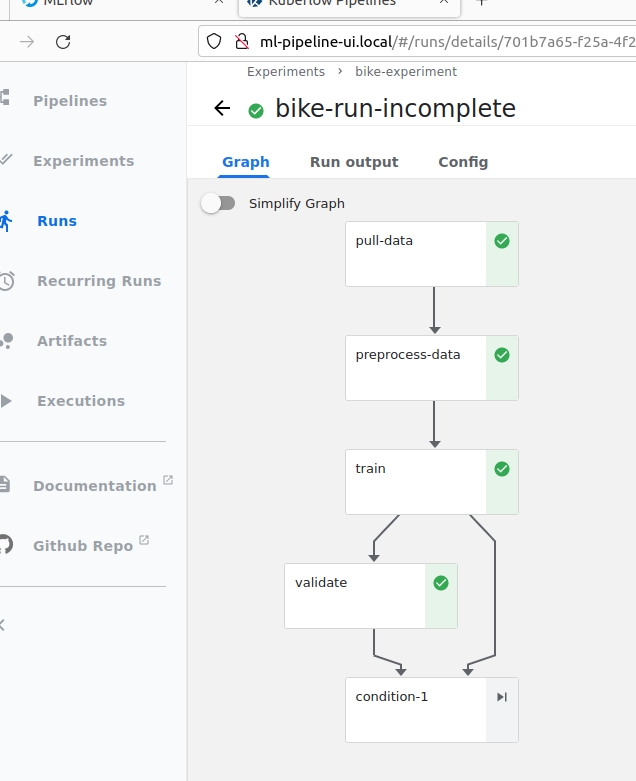

---

In summary, your PDF file should have the following four screenshots: 

1) the Kubeflow Pipelines UI showing a succeeded KFP run of this KFP pipeline
2) the MLflow UI of the created MLflow experiment
3) the MLflow UI of the registered model
4) the Kubeflow PIpelines UI of a KFP run where the deployment task is skipped due to the failed validation. 
